# BOOTSTRAP BONDS TO CREATE A ZERO CURVE

In this notebook I show how you can build the implied zero curve from bond prices.

In [1]:
import sys
sys.path.append("..")
sys.path.append("..\\..")

In [2]:
import datetime as dt
import pandas as pd

In [3]:
from financepy.finutils.FinDayCount import FinDayCountTypes
from financepy.finutils.FinDate import FinDate
from financepy.products.bonds.FinBond import FinBond
from financepy.products.bonds.FinBondMarket import getTreasuryBondMarketConventions, FinBondMarkets
from financepy.market.curves.FinBondZeroCurve import FinBondZeroCurve

## Load Bond Data

I have downloaded some bond price data from the UK DMO

In [4]:
bondDataFrame = pd.read_csv('./data/giltbondprices.txt', sep='\t')

We'll use mid-market prices for our analysis

In [5]:
bondDataFrame['mid'] = 0.5*(bondDataFrame['bid'] + bondDataFrame['ask'])

We need to use UK bond conventions

In [6]:
accrualType, frequencyType, settlementDays = getTreasuryBondMarketConventions(FinBondMarkets.UNITED_KINGDOM)

In [7]:
frequencyType

<FinFrequencyTypes.SEMI_ANNUAL: 2>

In [8]:
today = FinDate(18,9,2012)
settlementDate = today.addWorkDays(settlementDays)
print("Settles:", settlementDate)

Settles: WED 19 SEP 2012


In [9]:
bonds = []
cleanPrices = []

In [10]:
for index, bondRow in bondDataFrame.iterrows():

    dateString = bondRow['maturity']
    matDatetime = dt.datetime.strptime(dateString, '%d-%b-%y')
    maturityDt = FinDate.fromDatetime(matDatetime)
    coupon = bondRow['coupon']/100.0
    bond = FinBond(maturityDt, coupon, frequencyType, accrualType)
    cleanPrice = bondRow['mid']
    
    bonds.append(bond)
    cleanPrices.append(cleanPrice)

## Bootstrapping the Bond Prices

We pass the bond prices and bonds and the bootstrap is done automatically

In [11]:
bondCurve = FinBondZeroCurve(settlementDate, bonds, cleanPrices)

Let's just check that this curve reprices the bond

In [12]:
for cleanPrice, bond in zip(cleanPrices,bonds):
    fittedPrice = bond.cleanPriceFromDiscountCurve(settlementDate, bondCurve)
    diff = fittedPrice - cleanPrice
    print("Market: %10.6f   Fitted: %10.6f   Diff: %10.7f"% (cleanPrice,fittedPrice,diff))

Market: 101.995000   Fitted: 101.995000   Diff:  0.0000000
Market: 107.920000   Fitted: 107.920000   Diff:  0.0000000
Market: 102.975000   Fitted: 102.975000   Diff:  0.0000000
Market: 109.355000   Fitted: 109.355000   Diff:  0.0000000
Market: 105.625000   Fitted: 105.625000   Diff: -0.0000000
Market: 112.980000   Fitted: 112.980000   Diff:  0.0000000
Market: 124.470000   Fitted: 124.470000   Diff: -0.0000000
Market: 104.980000   Fitted: 104.980000   Diff:  0.0000000
Market: 113.495000   Fitted: 113.495000   Diff:  0.0000000
Market: 138.570000   Fitted: 138.570000   Diff:  0.0000002
Market: 121.790000   Fitted: 121.790000   Diff:  0.0000000
Market: 121.345000   Fitted: 121.345000   Diff:  0.0000003
Market: 116.815000   Fitted: 116.815000   Diff:  0.0000000
Market: 124.300000   Fitted: 124.300000   Diff:  0.0000000
Market: 117.375000   Fitted: 117.375000   Diff: -0.0000000
Market: 152.930000   Fitted: 152.930000   Diff:  0.0000000
Market: 117.695000   Fitted: 117.695000   Diff: -0.00000

What does the zero rate curve look like

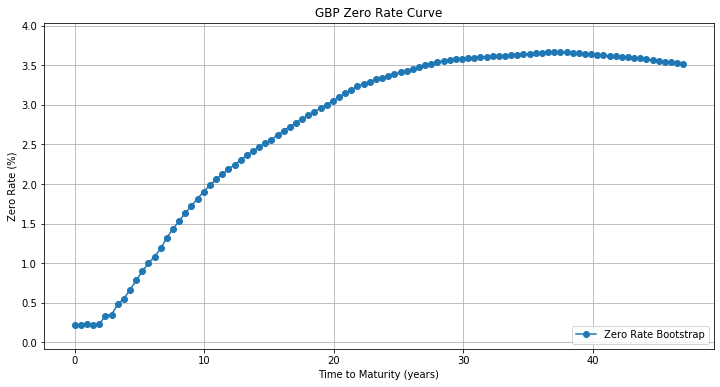

In [13]:
bondCurve.plot("GBP Zero Rate Curve")

## Forward Curve

How about the continuously compounded forwards. This gives us a detailed view on the term structure implied by the bond prices.

In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
times = np.linspace(0,10,2000)

In [38]:
fwds = bondCurve.fwd(times)

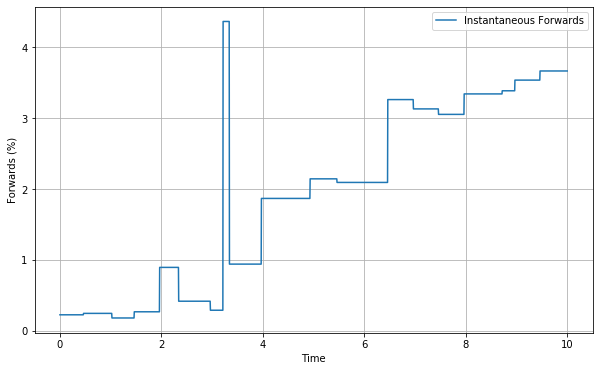

In [40]:
plt.figure(figsize=(10,6))
plt.plot(times,fwds*100, label="Instantaneous Forwards")
plt.xlabel("Time")
plt.ylabel("Forwards (%)")
plt.legend()
plt.grid()

Looks like there is some anomaly or mispricing around 3 years. As it does not last for long, it is probably not significant. 

Copyright (c) 2019, Dominic O'Kane 